In [ ]:
from google.colab import drive
import os
import sys
import zipfile

## Setup

In [ ]:
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/ml/ml_Assignment4'
os.chdir(PROJECT_PATH)
sys.path.append('./src')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle wandb seaborn scikit-learn

In [ ]:
from google.colab import files
import json

uploaded = files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
  f.write(uploaded['kaggle.json'].decode('utf-8'))
os.chmod('/root/.kaggle/kaggle.json', 0o600)

Saving kaggle.json to kaggle.json


In [ ]:
import kaggle

kaggle.api.competition_download_files(
        'challenges-in-representation-learning-facial-expression-recognition-challenge',
        path='./content/drive/MyDrive/ml/ml_Assignment4/data'
    )

In [ ]:
with zipfile.ZipFile('./content/drive/MyDrive/ml/ml_Assignment4/data/challenges-in-representation-learning-facial-expression-recognition-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/raw')

In [ ]:
import wandb

In [ ]:
wandb.login(key='')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egval20 (gval0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

#Data Exploration

In [ ]:
train_data = pd.read_csv('./data/raw/train.csv')

In [ ]:
print("📋 Dataset Basic Information:")
print(f"Dataset shape: {train_data.shape}")
print(f"Columns: {train_data.columns.tolist()}")
print(f"Total samples: {len(train_data):,}")
print(f"\n🔍 Missing Values:")
print(train_data.isnull().sum())

# Check if test data exists
if os.path.exists('./data/raw/test.csv'):
    test_data = pd.read_csv('./data/raw/test.csv')
    print(f"\n📋 Test Dataset Info:")
    print(f"Test shape: {test_data.shape}")
    print(f"Test columns: {test_data.columns.tolist()}")
else:
    print("\n📋 Test dataset not found (will be released later)")

📋 Dataset Basic Information:
Dataset shape: (28709, 2)
Columns: ['emotion', 'pixels']
Total samples: 28,709

🔍 Missing Values:
emotion    0
pixels     0
dtype: int64

📋 Test Dataset Info:
Test shape: (7178, 1)
Test columns: ['pixels']


In [ ]:
wandb.init(
    project="facial-expression-recognition",
    name="data_exploration",
    job_type="data_analysis",
    tags=["exploration", "analysis"]
)

In [ ]:
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

In [ ]:
emotion_counts = train_data['emotion'].value_counts().sort_index()

print("Emotion Distribution:")
print("-" * 30)
for emotion_id, count in emotion_counts.items():
    emotion_name = emotion_labels[emotion_id]
    percentage = (count / len(train_data)) * 100
    print(f"{emotion_name:10}: {count:5,} ({percentage:5.1f}%)")

Emotion Distribution:
------------------------------
Angry     : 3,995 ( 13.9%)
Disgust   :   436 (  1.5%)
Fear      : 4,097 ( 14.3%)
Happy     : 7,215 ( 25.1%)
Sad       : 4,830 ( 16.8%)
Surprise  : 3,171 ( 11.0%)
Neutral   : 4,965 ( 17.3%)


In [ ]:
emotion_dist_data = []
for emotion_id, count in emotion_counts.items():
    emotion_dist_data.append([emotion_labels[emotion_id], count])

wandb.log({
    "emotion_distribution_table": wandb.Table(
        data=emotion_dist_data,
        columns=["Emotion", "Count"]
    ),
    "total_samples": len(train_data),
    "num_classes": len(emotion_labels)
})

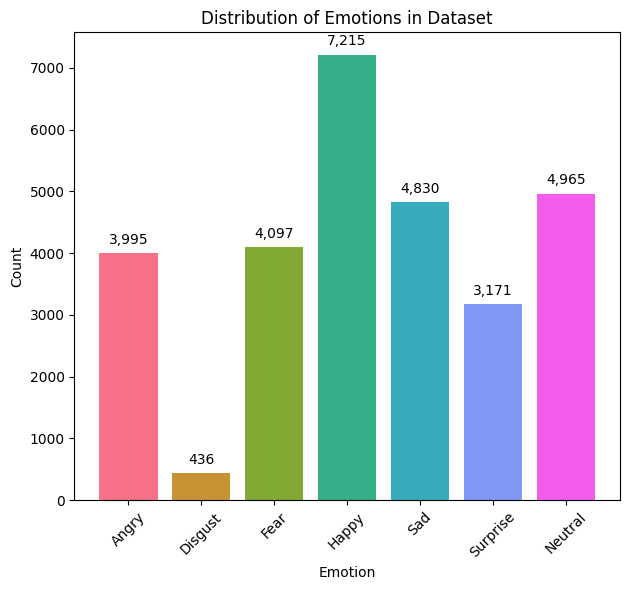

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(emotion_counts)), emotion_counts.values,
               color=sns.color_palette("husl", len(emotion_counts)))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Dataset')
plt.xticks(range(len(emotion_counts)),
           [emotion_labels[i] for i in emotion_counts.index], rotation=45)
for bar, count in zip(bars, emotion_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
            f'{count:,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
wandb.log({"emotion_distribution_plot": wandb.Image(plt)})
plt.show()

Sample Images

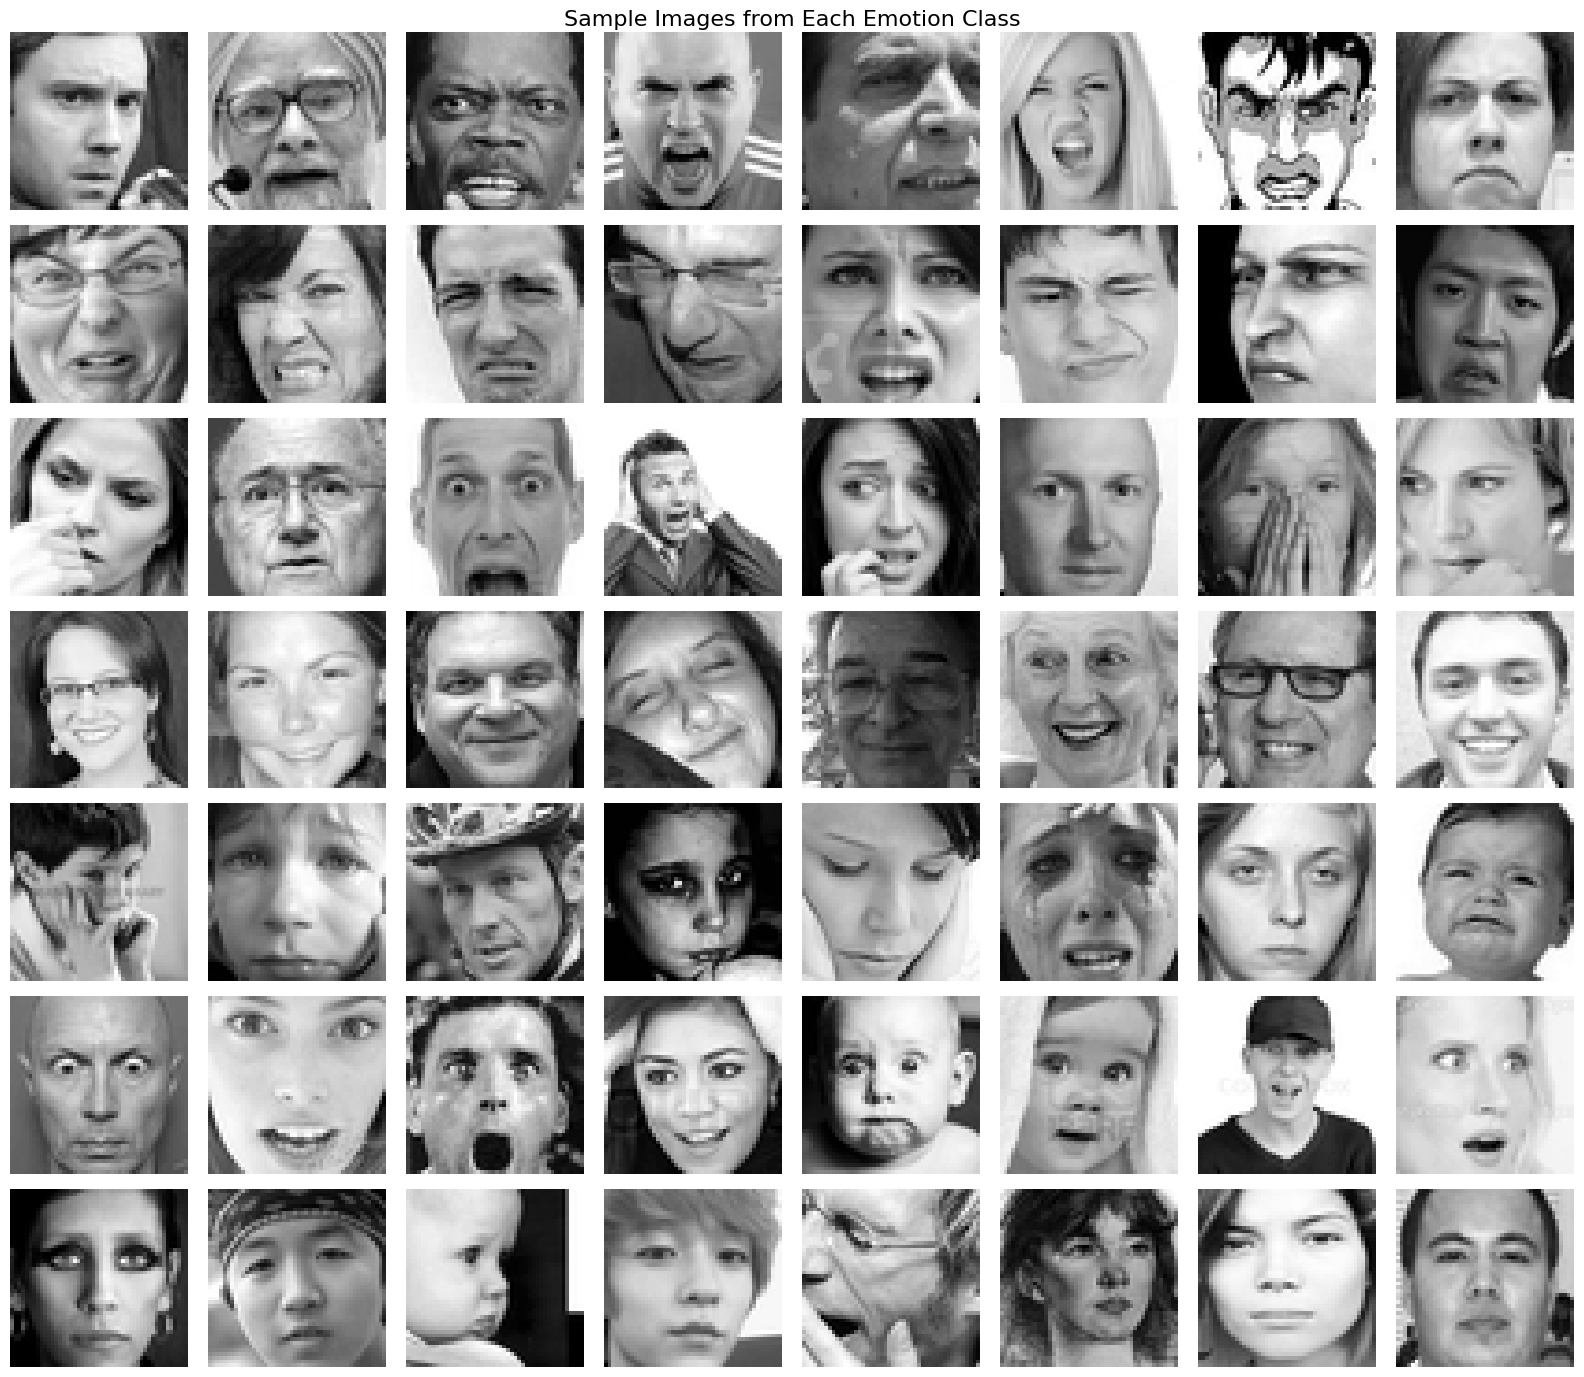

In [ ]:
def show_sample_images():
    fig, axes = plt.subplots(7, 8, figsize=(16, 14))
    fig.suptitle('Sample Images from Each Emotion Class', fontsize=16, y=0.98)

    for emotion_id in range(7):
        emotion_samples = train_data[train_data['emotion'] == emotion_id].head(8)
        emotion_name = emotion_labels[emotion_id]

        for i, (_, row) in enumerate(emotion_samples.iterrows()):
            pixels = np.array([int(pixel) for pixel in row['pixels'].split()], dtype=np.uint8)
            image = pixels.reshape(48, 48)

            axes[emotion_id, i].imshow(image, cmap='gray')
            axes[emotion_id, i].axis('off')

            if i == 0:
                axes[emotion_id, i].set_ylabel(emotion_name, rotation=90,
                                             fontsize=12, labelpad=20)

    plt.tight_layout()
    wandb.log({"sample_images_by_class": wandb.Image(plt)})
    plt.show()

show_sample_images()


 Pixel Intensity Analysis:
----------------------------------------
Overall pixel statistics (sample of 5,000 images):
  Mean: 129.46
  Std:  65.06
  Min:  0
  Max:  255


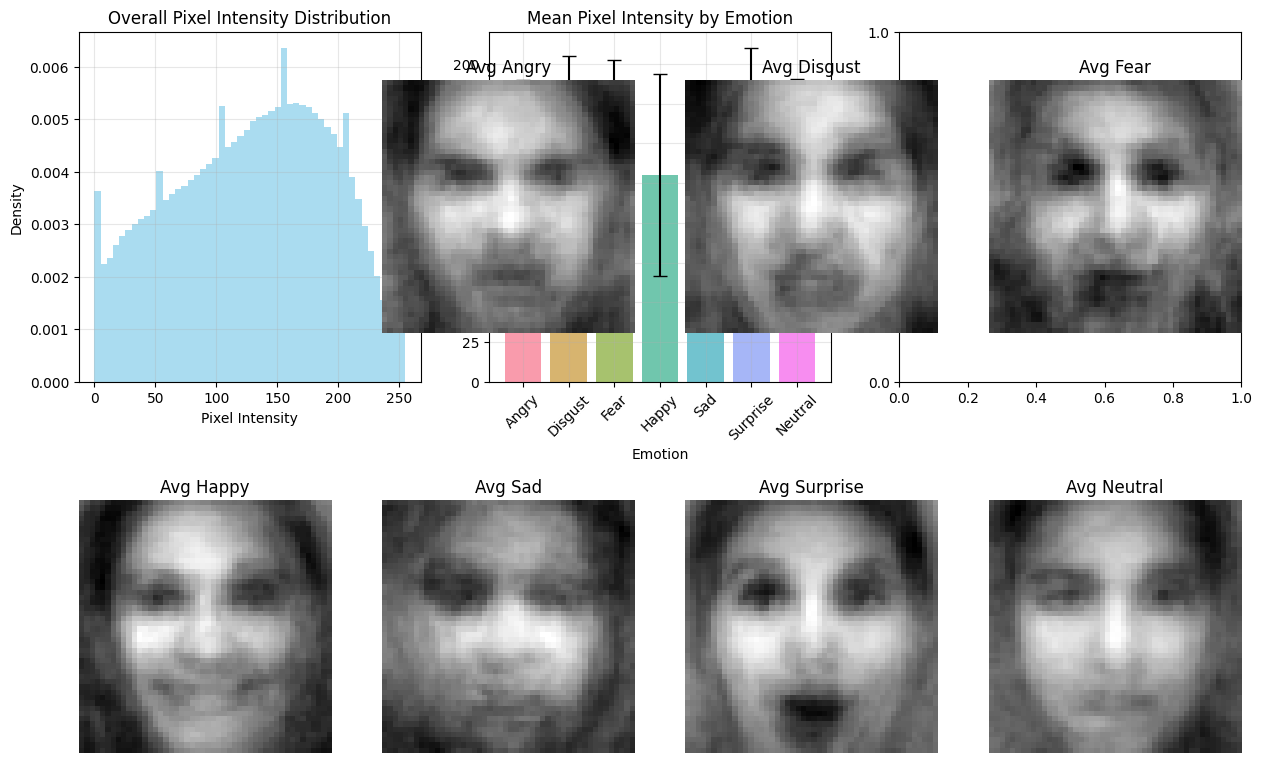

In [ ]:
def analyze_pixel_statistics():
    print(" Pixel Intensity Analysis:")
    print("-" * 40)

    all_pixels = []
    emotion_pixels = {i: [] for i in range(7)}
    sample_size = min(5000, len(train_data))
    sample_data = train_data.sample(n=sample_size, random_state=42)

    for _, row in sample_data.iterrows():
        pixels = np.array([int(pixel) for pixel in row['pixels'].split()], dtype=np.uint8)
        all_pixels.extend(pixels)
        emotion_pixels[row['emotion']].extend(pixels)
    all_pixels = np.array(all_pixels)
    print(f"Overall pixel statistics (sample of {sample_size:,} images):")
    print(f"  Mean: {np.mean(all_pixels):.2f}")
    print(f"  Std:  {np.std(all_pixels):.2f}")
    print(f"  Min:  {np.min(all_pixels)}")
    print(f"  Max:  {np.max(all_pixels)}")
    wandb.log({
        "pixel_mean": np.mean(all_pixels),
        "pixel_std": np.std(all_pixels),
        "pixel_min": np.min(all_pixels),
        "pixel_max": np.max(all_pixels)
    })

    # Plot pixel distribution
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.hist(all_pixels, bins=50, alpha=0.7, color='skyblue', density=True)
    plt.title('Overall Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.subplot(2, 3, 2)
    emotion_means = []
    emotion_stds = []

    for emotion_id in range(7):
        if emotion_pixels[emotion_id]:  # Check if not empty
            pixels = np.array(emotion_pixels[emotion_id])
            emotion_means.append(np.mean(pixels))
            emotion_stds.append(np.std(pixels))
        else:
            emotion_means.append(0)
            emotion_stds.append(0)

    x_pos = range(7)
    plt.bar(x_pos, emotion_means, yerr=emotion_stds, capsize=5,
            color=sns.color_palette("husl", 7), alpha=0.7)
    plt.xlabel('Emotion')
    plt.ylabel('Mean Pixel Intensity')
    plt.title('Mean Pixel Intensity by Emotion')
    plt.xticks(x_pos, [emotion_labels[i] for i in range(7)], rotation=45)
    plt.grid(True, alpha=0.3)

    # Log per-emotion stats
    emotion_stats_data = []
    for i, (mean, std) in enumerate(zip(emotion_means, emotion_stds)):
        emotion_stats_data.append([emotion_labels[i], mean, std])
        wandb.log({f"{emotion_labels[i]}_pixel_mean": mean})

    wandb.log({
        "emotion_pixel_stats": wandb.Table(
            data=emotion_stats_data,
            columns=["Emotion", "Mean_Pixel_Intensity", "Std_Pixel_Intensity"]
        )
    })

    plt.subplot(2, 3, 3)
    avg_images = []
    for emotion_id in range(7):
        emotion_data = train_data[train_data['emotion'] == emotion_id].head(100)
        if len(emotion_data) > 0:
            images = []
            for _, row in emotion_data.iterrows():
                pixels = np.array([int(pixel) for pixel in row['pixels'].split()], dtype=np.uint8)
                images.append(pixels.reshape(48, 48))
            avg_images.append(np.mean(images, axis=0))
        else:
            avg_images.append(np.zeros((48, 48)))

    for i, (emotion_id, avg_img) in enumerate(zip(range(7), avg_images)):
        plt.subplot(2, 4, i + 2)
        plt.imshow(avg_img, cmap='gray')
        plt.title(f'Avg {emotion_labels[emotion_id]}')
        plt.axis('off')

    plt.tight_layout()
    wandb.log({"pixel_analysis": wandb.Image(plt)})
    plt.show()

    return emotion_means, emotion_stds

emotion_means, emotion_stds = analyze_pixel_statistics()

In [ ]:
summary_stats = {
    "dataset_size": len(train_data),
    "num_classes": 7,
    "image_dimensions": "48x48",
    "most_common_emotion": emotion_labels[train_data['emotion'].value_counts().idxmax()],
    "least_common_emotion": emotion_labels[train_data['emotion'].value_counts().idxmin()]
}

wandb.log(summary_stats)

In [ ]:
wandb.finish()

Angry_pixel_mean,▁
Disgust_pixel_mean,▁
Fear_pixel_mean,▁
Happy_pixel_mean,▁
Neutral_pixel_mean,▁
Sad_pixel_mean,▁
Surprise_pixel_mean,▁
dataset_size,▁
num_classes,▁▁
pixel_max,▁
pixel_mean,▁
